In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy, os, glob, sys

In [2]:
ft_path = '/Users/jvanbaar/Dropbox (Brown)/Python'
sys.path.append(ft_path)
import FigureTools

In [3]:
blockDat = pd.read_csv('/Users/jvanbaar/Dropbox (Brown)/Postdoc FHL/JEROEN/SOC_STRUCT_LEARN/Study1_MTurk'
               +'/Data/Cleaned/blockDat.csv',index_col = 0, dtype={ 'subID':str})
subIDs = blockDat['subID'].unique()
print(len(subIDs))
blockDat.head()

150


,subID,Type_Total,Type,Variant,Confidence,Score
0,2003,opt_inv,opt,inv,50.625,0.4375
1,2003,opt_nat,opt,nat,89.375,1.0000
2,2003,pess_inv,pess,inv,50.000,0.5000
3,2003,pess_nat,pess,nat,52.500,0.5625
4,2004,opt_inv,opt,inv,53.125,0.2500


In [4]:
combs = []
for model1 in ['0','1']:
    for model2 in ['0','1']:
        for model3 in ['0','1']:
            for model4 in ['0','1']:
                combs.append(model1+model2+model3+model4)
combs = combs[1:]
# combs

In [5]:
niter = 10
results_Feature_RL = pd.DataFrame()
for subID in subIDs:
    print(subID, end=',')
    filename = glob.glob('FeatureRL/Results_Aug3/subInd-*_subID-*%s_niter-%i_results.csv'%(
        subID, niter))[0]
#     print(filename)
    results = pd.read_csv(filename,header=0, index_col=None, dtype = {'subID':str})
    results['subID'] = subID
    results_Feature_RL = results_Feature_RL.append(results.iloc[:119,:])
results_Feature_RL = results_Feature_RL.reset_index(drop=True)

2003,2004,2005,2006,2008,2009,2011,2013,2014,2015,2016,2019,2020,2021,2022,2023,2024,2025,2026,2027,2029,2030,2031,2032,2033,2034,2035,2037,2039,2040,2041,2042,2044,2045,2046,2047,2048,2050,2051,2053,2054,2055,2057,2058,2059,2062,2063,2065,2066,2067,2069,2070,2071,2072,2073,2074,2075,2079,2080,2081,2082,2083,2088,2089,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104,2105,2107,2108,2109,2110,2111,2112,2113,2114,2115,2118,2119,2123,2124,2125,2126,2128,2129,2130,2131,2132,2133,2134,2135,2136,2137,2138,2139,2140,2141,2142,2143,2144,2145,2146,2147,2150,2152,2154,2156,2157,2158,2159,2160,2161,2162,2163,2164,2165,2166,2168,2169,2170,2171,2174,3005,3006,3008,3009,3011,3012,3013,3016,3017,3018,3019,3020,3021,3022,3023,3024,3026,4000,4001,

##### Parse feature combination

In [6]:
results_Feature_RL['comb'] = [combs[combInd-1] for combInd in results_Feature_RL['combInd'].values]
results_Feature_RL.head()

,fitTo,combInd,asymm_LR,bounded_weights,bestNLL,param1,param2,param3,param4,param5,param6,param7,param8,param9,param10,subID,comb
0,1,1,0,0,42.26,1.38,0.27,-1.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,0001
1,1,1,0,1,43.80,4.59,0.06,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,0001
2,1,1,1,0,40.97,0.01,10.00,0.06,-15.63,NaN,NaN,NaN,NaN,NaN,NaN,2003,0001
3,1,1,1,1,43.69,0.01,9.96,0.02,0.00,NaN,NaN,NaN,NaN,NaN,NaN,2003,0001
4,1,2,0,0,44.03,0.32,0.17,0.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,0010


In [7]:
paramCols = []
cols = list(results_Feature_RL.columns.values)
for ni,name in enumerate(cols):
    if 'param' in name:
        paramCols.append(ni)
paramCols = [cols[pc] for pc in paramCols]

In [8]:
def penalizedModelFit(NLL,nParams, whichOne = 'both'):
    AIC = 2*nParams - 2 * -NLL
    BIC = nParams * np.log(64) - 2 * -NLL
    # see https://en.wikipedia.org/wiki/Bayesian_information_criterion and 
    # https://en.wikipedia.org/wiki/Akaike_information_criterion
    if whichOne == 'both':
        return AIC, BIC
    elif whichOne == 'AIC':
        return AIC
    elif whichOne == 'BIC':
        return BIC
    else:
        ValueError('invalid value for argument whichOne')

In [9]:
for i in results_Feature_RL.index:
#     fitToNParams = (results_all.loc[i,'fitTo']-1)*3
#     combNParams = combs[(results_all.loc[i,'combInd']-1)].count('1')
#     asymm_LRNParams = (results_all.loc[i,'asymm_LR'])
#     nParams = 2 + combNParams + asymm_LRNParams + fitToNParams
    nParams = sum(~np.isnan(results_Feature_RL.loc[i,paramCols].values.astype(float)))
#     print(nParams)
    AIC, BIC = penalizedModelFit(results_Feature_RL.loc[i,'bestNLL'],nParams)
#     print(BIC)
    results_Feature_RL.loc[i,'AIC'] = AIC
    results_Feature_RL.loc[i,'BIC'] = BIC

In [10]:
results_Feature_RL['bestModel'] = False
for subID in results_Feature_RL['subID'].unique():
    subDat = results_Feature_RL.query('subID == @subID'
                                     ).sort_values(by='BIC',ascending=True).copy()
    bestModel = subDat.iloc[0]
    bestBIC = bestModel['BIC']
    results_Feature_RL.loc[(results_Feature_RL['subID']==subID) & 
                           (results_Feature_RL['BIC']==bestBIC),'bestModel'] = True

In [11]:
results_Feature_RL.shape

(17850, 20)

In [12]:
results_Feature_RL.head()

,fitTo,combInd,asymm_LR,bounded_weights,bestNLL,param1,param2,param3,param4,param5,param6,param7,param8,param9,param10,subID,comb,AIC,BIC,bestModel
0,1,1,0,0,42.26,1.38,0.27,-1.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,0001,90.52,96.996649,False
1,1,1,0,1,43.80,4.59,0.06,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,0001,93.60,100.076649,False
2,1,1,1,0,40.97,0.01,10.00,0.06,-15.63,NaN,NaN,NaN,NaN,NaN,NaN,2003,0001,89.94,98.575532,False
3,1,1,1,1,43.69,0.01,9.96,0.02,0.00,NaN,NaN,NaN,NaN,NaN,NaN,2003,0001,95.38,104.015532,False
4,1,2,0,0,44.03,0.32,0.17,0.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,0010,94.06,100.536649,False


In [13]:
results_Feature_RL.to_csv('FeatureRL/Results_Aug3/results_all.csv')

## Single subject

In [15]:
subID = '2051'
results_Feature_RL.query('subID == @subID & comb == "1111"')

,fitTo,combInd,asymm_LR,bounded_weights,bestNLL,param1,param2,param3,param4,param5,param6,param7,param8,param9,param10,subID,comb,AIC,BIC,bestModel
4578,1,15,0,0,18.10,0.06,1.62,6.13,6.81,0.09,-0.06,NaN,NaN,NaN,NaN,2051,1111,48.20,61.153299,False
4579,1,15,0,1,18.15,0.22,0.43,11.78,14.51,0.22,0.12,NaN,NaN,NaN,NaN,2051,1111,48.30,61.253299,False
4580,1,15,1,0,17.98,0.15,0.06,1.09,9.52,10.54,0.31,-0.02,NaN,NaN,NaN,2051,1111,49.96,65.072182,False
4581,1,15,1,1,18.11,0.35,0.24,0.40,12.48,15.46,0.02,0.20,NaN,NaN,NaN,2051,1111,50.22,65.332182,False
4638,2,15,0,0,48.00,9.14,0.01,-2.23,-8.62,-17.03,-11.17,4.17,0.46,3.51,NaN,2051,1111,114.00,133.429948,False
4639,2,15,0,1,40.42,2.37,0.05,0.70,15.77,10.21,10.29,4.26,0.43,3.30,NaN,2051,1111,98.84,118.269948,False
4640,2,15,1,0,32.81,1.22,4.44,0.08,-2.12,18.55,-8.92,-8.69,2.63,0.45,2.46,2051,1111,85.62,107.208831,False


## Load

In [37]:
results_Feature_RL = pd.read_csv('FeatureRL/Results_Aug3/results_all.csv', index_col = 0,
                                dtype = {'comb':'str', 'subID':'str'})
results_Feature_RL.head()

,fitTo,combInd,asymm_LR,bounded_weights,bestNLL,param1,param2,param3,param4,param5,param6,param7,param8,param9,param10,subID,comb,AIC,BIC,bestModel
0,1,1,0,0,42.26,1.38,0.27,-1.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,0001,90.52,96.996649,False
1,1,1,0,1,43.80,4.59,0.06,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,0001,93.60,100.076649,False
2,1,1,1,0,40.97,0.01,10.00,0.06,-15.63,NaN,NaN,NaN,NaN,NaN,NaN,2003,0001,89.94,98.575532,False
3,1,1,1,1,43.69,0.01,9.96,0.02,0.00,NaN,NaN,NaN,NaN,NaN,NaN,2003,0001,95.38,104.015532,False
4,1,2,0,0,44.03,0.32,0.17,0.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,0010,94.06,100.536649,False


## Model comparison overall

##### All models – BIC

In [9]:
plotDat = results_Feature_RL.query('fitTo == 1 & asymm_LR == 0').copy()
means = plotDat[['comb','bounded_weights','BIC']].groupby(
    ['comb','bounded_weights']).mean().sort_values(by='BIC',ascending=True).reset_index()
combOrder = means['comb'].unique()
print(combOrder)

[1100  100 1110  110 1101  101 1111  111   11 1011    1 1001   10 1000
 1010]


/Applications/anaconda3/envs/structLearn/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


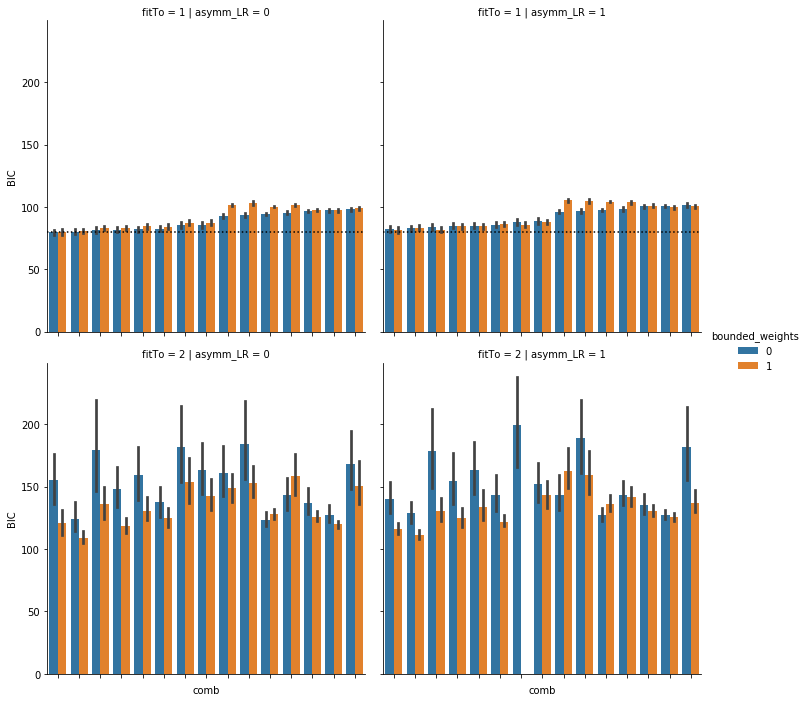

In [10]:
g = sns.catplot(kind='bar',data=results_Feature_RL,x='comb',y='BIC',col = 'asymm_LR', row='fitTo',
           hue = 'bounded_weights', order = combOrder, row_order = [1,2])
g.set_xticklabels(rotation=45);
ax1, ax2 = g.axes[0]
ax1.axhline(means.loc[0,'BIC'], color='k',ls=':')
ax2.axhline(means.loc[0,'BIC'], color='k',ls=':');

##### All models - AIC

In [87]:
plotDat = results_Feature_RL.query('fitTo == 1 & asymm_LR == 0').copy()
means = plotDat[['comb','bounded_weights','AIC']].groupby(
    ['comb','bounded_weights']).mean().sort_values(by='AIC',ascending=True).reset_index()
combOrder = means['comb'].unique()
print(combOrder)

['1110' '1100' '1101' '1111' '0110' '0100' '0101' '0111' '1011' '0011'
 '1001' '0001' '1010' '0010' '1000']


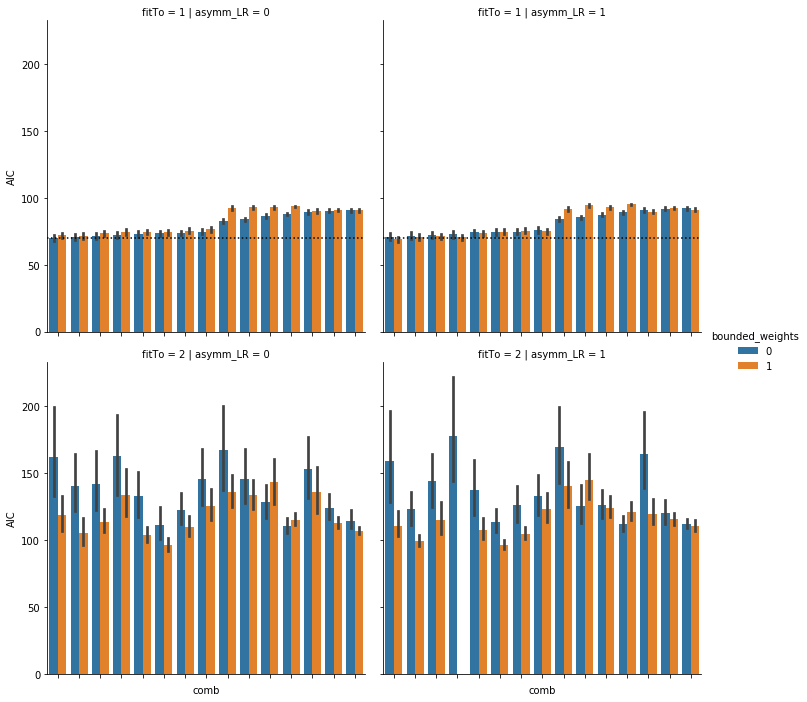

In [88]:
g = sns.catplot(kind='bar',data=results_Feature_RL,
                x='comb',y='AIC',col = 'asymm_LR', row='fitTo',
           hue = 'bounded_weights', order = combOrder, row_order = [1,2])
g.set_xticklabels(rotation=45);
ax1, ax2 = g.axes[0]
ax1.axhline(means.loc[0,'AIC'], color='k',ls=':')
ax2.axhline(means.loc[0,'AIC'], color='k',ls=':');

##### Pretty plot for choice-only

In [19]:
plotDat = results_Feature_RL.query('fitTo == 1 & asymm_LR == 1').copy()
means = plotDat[['comb','asymm_LR','bounded_weights','AIC']].groupby(
    ['comb','asymm_LR','bounded_weights']).mean().sort_values(
    by='AIC',ascending=True).reset_index()
combOrder = means['comb'].unique()
means.head()

,comb,asymm_LR,bounded_weights,AIC
0,1110,1,1,68.938267
1,1111,1,1,70.488400
2,1100,1,1,70.617867
3,1110,1,0,71.132933
4,1101,1,1,71.455867


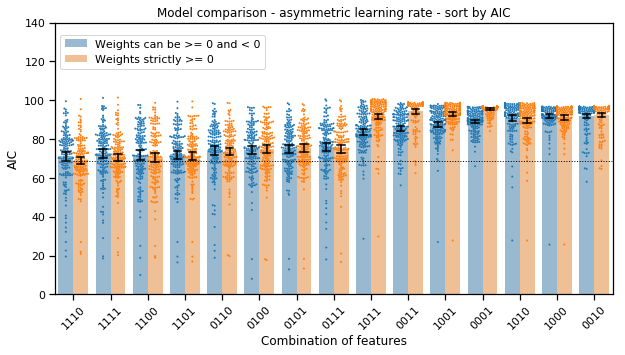

In [20]:
sns.set_context('notebook')
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = [10,5]);
sns.barplot(data = plotDat.query('asymm_LR==1'), x = 'comb', y = 'AIC',
            hue = 'bounded_weights', ax = ax,
            alpha = 0.5, errwidth = 0, zorder = 1, order = combOrder);
[hand, lab] = ax.get_legend_handles_labels();
sns.swarmplot(data = plotDat.query('asymm_LR==1'), x = 'comb', y = 'AIC',
              hue = 'bounded_weights', dodge = True, ax = ax,
            alpha = 1, size = 2, zorder = 2, order = combOrder);
sns.barplot(data = plotDat.query('asymm_LR==1'), x = 'comb', y = 'AIC',
            hue = 'bounded_weights', ax = ax,
            alpha = 0, errwidth = 1.5, capsize = .2, errcolor = 'k', zorder = 3, order = combOrder);
plt.plot([0,15],[np.min(means.AIC), np.min(means.AIC)], 'k:', lw=1);
plt.xticks(rotation=45);
plt.ylim([0,140]);
plt.legend(hand, ['Weights can be >= 0 and < 0','Weights strictly >= 0'], loc = [0.01, 0.83]);
ax.set(xlabel = 'Combination of features', title = 
       'Model comparison - asymmetric learning rate - sort by AIC');
# plt.savefig('/Users/jvanbaar/Desktop/modelCompAIC.pdf',bbox_inches='tight');

In [21]:
plotDat = results_Feature_RL.query('fitTo == 1 & asymm_LR == 0').copy()
means = plotDat[['comb','asymm_LR','bounded_weights','BIC']].groupby(
    ['comb','asymm_LR','bounded_weights']).mean().sort_values(
    by='BIC',ascending=True).reset_index()
combOrder = means['comb'].unique()
means.head()

,comb,asymm_LR,bounded_weights,BIC
0,1100,0,0,79.675932
1,1100,0,1,80.121132
2,0100,0,0,80.238116
3,0100,0,1,80.768116
4,1110,0,0,81.214549


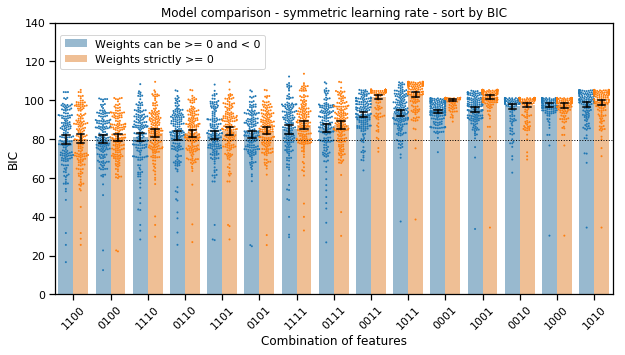

In [22]:
sns.set_context('notebook')
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = [10,5]);
sns.barplot(data = plotDat, x = 'comb', y = 'BIC', hue = 'bounded_weights', ax = ax,
            alpha = 0.5, errwidth = 0, zorder = 1, order = combOrder);
[hand, lab] = ax.get_legend_handles_labels();
sns.swarmplot(data = plotDat, x = 'comb', y = 'BIC', hue = 'bounded_weights', dodge = True, ax = ax,
            alpha = 1, size = 2, zorder = 2, order = combOrder);
sns.barplot(data = plotDat, x = 'comb', y = 'BIC', hue = 'bounded_weights', ax = ax,
            alpha = 0, errwidth = 1.5, capsize = .2, errcolor = 'k', zorder = 3, order = combOrder);
plt.plot([0,15],[np.min(means.BIC), np.min(means.BIC)], 'k:', lw=1);
plt.xticks(rotation=45);
plt.ylim([0,140]);
plt.legend(hand, ['Weights can be >= 0 and < 0','Weights strictly >= 0'], loc = [0.01, 0.83]);
ax.set(xlabel = 'Combination of features', title = 
       'Model comparison - symmetric learning rate - sort by BIC');
# plt.savefig('/Users/jvanbaar/Desktop/modelCompBIC.pdf',bbox_inches='tight');

## Plot with bounded_LR = 0 and asymm_LR = 0, BIC - split by features only

In [59]:
import re

In [75]:
plotDat.head()

,fitTo,combInd,asymm_LR,bounded_weights,bestNLL,param1,param2,param3,param4,param5,...,param7,param8,param9,param10,subID,comb,AIC,BIC,bestModel,comb_letters
0,1,1,0,0,42.26,1.38,0.27,-1.66,NaN,NaN,...,NaN,NaN,NaN,NaN,2003,0001,90.52,96.996649,False,Re
4,1,2,0,0,44.03,0.32,0.17,0.84,NaN,NaN,...,NaN,NaN,NaN,NaN,2003,0010,94.06,100.536649,False,Ri
8,1,3,0,0,42.18,0.42,0.27,1.56,-2.24,NaN,...,NaN,NaN,NaN,NaN,2003,0011,92.36,100.995532,False,Ri-Re
12,1,4,0,0,33.58,1.17,0.51,3.91,NaN,NaN,...,NaN,NaN,NaN,NaN,2003,0100,73.16,79.636649,False,Gr
16,1,5,0,0,32.58,0.99,0.50,4.03,0.43,NaN,...,NaN,NaN,NaN,NaN,2003,0101,73.16,81.795532,False,Gr-Re


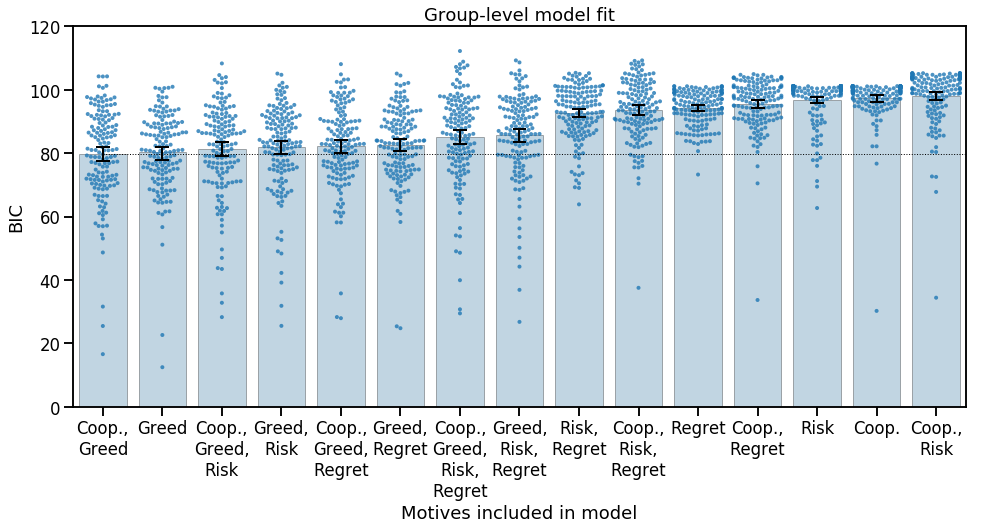

In [87]:
plotDat = results_Feature_RL.query('fitTo == 1 & asymm_LR == 0 & bounded_weights == 0').copy()
letter_list = ['Coop.','Greed','Risk','Regret']
plotDat['comb_letters'] = plotDat['comb'].apply(lambda x: 
                ',\n'.join(letter_list[k] for k in [i.span()[0] for i in re.finditer('1',x)]))

means = plotDat[['comb_letters','BIC']].groupby('comb_letters').mean().sort_values(by='BIC',ascending=True).reset_index()
combOrder = means['comb_letters'].unique()
means.head()

sns.set_context('talk')
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = [16,7]);
sns.barplot(data = plotDat, x = 'comb_letters', y = 'BIC', color = sns.color_palette('tab10')[0], ax = ax,
            alpha = 0.3, errwidth = 0, zorder = 1, order = combOrder, edgecolor = 'k', linewidth = 1);
[hand, lab] = ax.get_legend_handles_labels();
sns.swarmplot(data = plotDat, x = 'comb_letters', y = 'BIC', ax = ax, color = sns.color_palette('tab10')[0],
            alpha = .8, size = 4, zorder = 2, order = combOrder);
sns.barplot(data = plotDat, x = 'comb_letters', y = 'BIC', ax = ax,
            alpha = 0, errwidth = 2, capsize = .2, errcolor = 'k', zorder = 3, order = combOrder);
plt.plot([0,15],[np.min(means.BIC), np.min(means.BIC)], 'k:', lw=1);
plt.xticks(rotation=0);
plt.ylim([0,120]);
# plt.legend(hand, ['Weights can be >= 0 and < 0','Weights strictly >= 0'], loc = [0.01, 0.83]);
ax.set(xlabel = 'Motives included in model', title = 'Group-level model fit');
plt.savefig('/Users/jvanbaar/Desktop/modelCompBIC_motiveLabels.pdf',bbox_inches='tight',
           transparent = True);

## When using asymmetric learning rate, do the fitted parameters make sense?

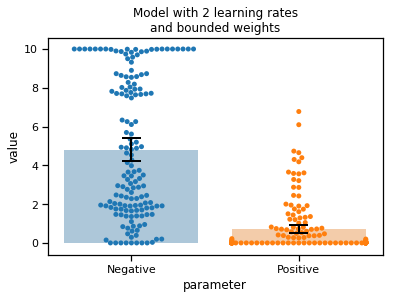

In [424]:
plotDat = results_all.query('comb == "1110" & asymm_LR == 1 & bounded_weights == 1 & fitTo == 1'
                             )[['param1','param2','param2']].copy()
plotDat.columns = ['neg','pos','invTemp']
plotDat = plotDat.melt(var_name = 'parameter', value_name = 'value')
fig, ax = plt.subplots(1,1,figsize=[6,4])
sns.barplot(data = plotDat, x = 'parameter', y = 'value', ax = ax, alpha = .4, zorder = 0,
           errwidth = 0, order = ['neg','pos'])
sns.swarmplot(data = plotDat, x = 'parameter', y = 'value', ax = ax, zorder = 1, order = ['neg','pos'])
sns.barplot(data = plotDat, x = 'parameter', y = 'value', ax = ax, alpha = 0, zorder = 2,
           errwidth = 2, capsize = .1, errcolor = 'k', order = ['neg','pos'])
ax.set_xticklabels(['Negative','Positive'])
# plt.ylim([0,4])
plt.title('Model with 2 learning rates\nand bounded weights');

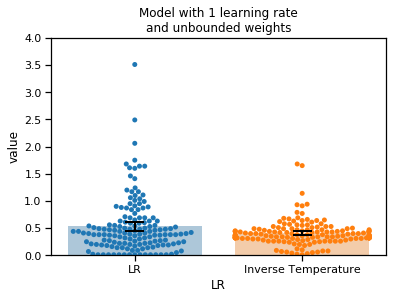

In [425]:
plotDat = results_all.query('comb == "1110" & asymm_LR == 0 & bounded_weights == 0 & fitTo == 1'
                             )[['param1','param2']].copy()
plotDat.columns = ['LR','Inverse Temperature']
plotDat = plotDat.melt(var_name = 'LR', value_name = 'value')
fig, ax = plt.subplots(1,1,figsize=[6,4])
sns.barplot(data = plotDat, x = 'LR', y = 'value', ax = ax, alpha = .4, zorder = 0,
           errwidth = 0)
sns.swarmplot(data = plotDat, x = 'LR', y = 'value', ax = ax, zorder = 1)
sns.barplot(data = plotDat, x = 'LR', y = 'value', ax = ax, alpha = 0, zorder = 2,
           errwidth = 2, capsize = .1, errcolor = 'k')
# ax.set_xticklabels(['Negative','Positive'])
plt.ylim([0,4])
plt.title('Model with 1 learning rate\nand unbounded weights');

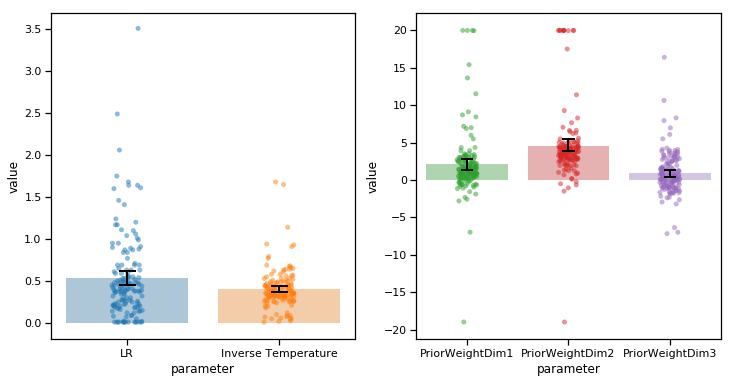

In [426]:
plotDat = results_all.query('comb == "1110" & asymm_LR == 0 & bounded_weights == 0 & fitTo == 1'
                             )[['param1','param2','param3','param4','param5']].copy()
plotDat.columns = ['LR','Inverse Temperature','PriorWeightDim1','PriorWeightDim2','PriorWeightDim3']
plotDat = plotDat.melt(var_name = 'parameter', value_name = 'value')
fig, ax = plt.subplots(1,2,figsize=[12,6])
sns.barplot(data = plotDat, x = 'parameter', y = 'value', ax = ax[0], alpha = .4, zorder = 0,
           errwidth = 0, order = ['LR','Inverse Temperature'])
sns.stripplot(data = plotDat, x = 'parameter', y = 'value', ax = ax[0], zorder = 1,size = 5, alpha=.5,
              order = ['LR','Inverse Temperature'])
sns.barplot(data = plotDat, x = 'parameter', y = 'value', ax = ax[0], alpha = 0, zorder = 2,
           errwidth = 2, capsize = .1, errcolor = 'k', order = ['LR','Inverse Temperature'])
sns.barplot(data = plotDat, x = 'parameter', y = 'value', ax = ax[1], alpha = .4, zorder = 0,
           errwidth = 0, order = ['PriorWeightDim1','PriorWeightDim2','PriorWeightDim3'], 
           palette = sns.color_palette('tab10',10)[2:])
sns.stripplot(data = plotDat, x = 'parameter', y = 'value', ax = ax[1], zorder = 1,size = 5, alpha=.5,
              order = ['PriorWeightDim1','PriorWeightDim2','PriorWeightDim3'], 
           palette = sns.color_palette('tab10',10)[2:])
sns.barplot(data = plotDat, x = 'parameter', y = 'value', ax = ax[1], alpha = 0, zorder = 2,
           errwidth = 2, capsize = .1, errcolor = 'k',
            order = ['PriorWeightDim1','PriorWeightDim2','PriorWeightDim3'], 
           palette = sns.color_palette('tab10',10)[2:])
# ax.set_xticklabels(['Negative','Positive'])
# plt.title('Negative vs positive learning rates\nfitted to participant data');

## Model fits for Bayesian ideal observer model

In [96]:
niter = 50
results_Bayes = pd.DataFrame()
for subID in subIDs:
    print(subID, end=',')
    filename = glob.glob('BayesianIO/Results/subInd-*_subID-*%s_niter-%i_results.csv'%(
        subID, niter))[0]
#     print(filename)
    results = pd.read_csv(filename,header=0, index_col=None)
    results['subID'] = subID
    results_Bayes = results_Bayes.append(results)
results_Bayes = results_Bayes.reset_index(drop=True)

2003,2004,2005,2006,2008,2009,2011,2013,2014,2015,2016,2019,2020,2021,2022,2023,2024,2025,2026,2027,2029,2030,2031,2032,2033,2034,2035,2037,2039,2040,2041,2042,2044,2045,2046,2047,2048,2050,2051,2053,2054,2055,2057,2058,2059,2062,2063,2065,2066,2067,2069,2070,2071,2072,2073,2074,2075,2079,2080,2081,2082,2083,2088,2089,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104,2105,2107,2108,2109,2110,2111,2112,2113,2114,2115,2118,2119,2123,2124,2125,2126,2128,2129,2130,2131,2132,2133,2134,2135,2136,2137,2138,2139,2140,2141,2142,2143,2144,2145,2146,2147,2150,2152,2154,2156,2157,2158,2159,2160,2161,2162,2163,2164,2165,2166,2168,2169,2170,2171,2174,3005,3006,3008,3009,3011,3012,3013,3016,3017,3018,3019,3020,3021,3022,3023,3024,3026,4000,4001,

In [97]:
paramCols = []
cols = list(results_Bayes.columns.values)
for ni,name in enumerate(cols):
    if 'param' in name:
        paramCols.append(ni)
paramCols = [cols[pc] for pc in paramCols]

In [98]:
for i in results_Bayes.index:
#     fitToNParams = (results_all.loc[i,'fitTo']-1)*3
#     combNParams = combs[(results_all.loc[i,'combInd']-1)].count('1')
#     asymm_LRNParams = (results_all.loc[i,'asymm_LR'])
#     nParams = 2 + combNParams + asymm_LRNParams + fitToNParams
    nParams = sum(~np.isnan(results_Bayes.loc[i,paramCols].values.astype(float)))
#     print(nParams)
    AIC, BIC = penalizedModelFit(results_Bayes.loc[i,'bestNLL'],nParams)
#     print(BIC)
    results_Bayes.loc[i,'AIC'] = AIC
    results_Bayes.loc[i,'BIC'] = BIC

In [99]:
results_Bayes.head()

,fitTo,bestNLL,param1,param2,param3,param4,param5,param6,param7,param8,param9,subID,AIC,BIC
0,1,33.62,100.00,1.00,100.00,1.49,1.00,0.43,NaN,NaN,NaN,2003,79.24,92.193299
1,2,40.10,52.34,18.76,40.86,14.39,4.09,0.47,3.01,0.30,1.76,2003,98.20,117.629948
2,1,39.93,100.00,1.00,1.00,1.00,1.00,0.50,NaN,NaN,NaN,2004,91.86,104.813299
3,2,48.42,69.34,71.40,45.23,3.04,34.09,0.50,2.74,0.41,4.06,2004,114.84,134.269948
4,1,38.30,100.00,1.00,13.00,1.00,1.00,0.50,NaN,NaN,NaN,2005,88.60,101.553299


/Applications/anaconda3/envs/structLearn/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


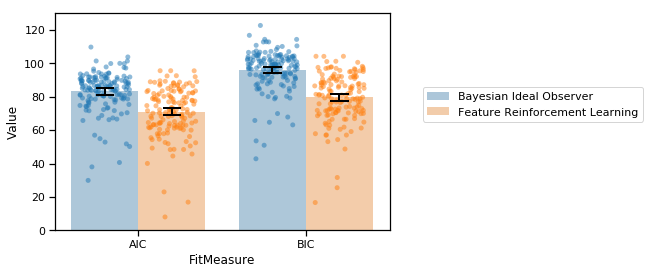

In [102]:
plotDat_Bayes = results_Bayes.query('fitTo == 1')[['AIC','BIC','subID']].melt(
    id_vars = 'subID', var_name = 'FitMeasure', value_name = 'Value')
plotDat_Bayes['Model'] = 'BayesianIO'
plotDat_Bayes.head()
plotDat_RL = results_Feature_RL.query(
    'fitTo == 1 & asymm_LR == 0 & bounded_weights == 0 & comb == "1100"'
                              )[['AIC','BIC','subID']].melt(
    id_vars = 'subID', var_name = 'FitMeasure', value_name = 'Value')
plotDat_RL['Model'] = 'FeatureRL'
plotDat_RL.head()
plotDat = plotDat_Bayes.append(plotDat_RL)
plotDat.shape
fig, ax = plt.subplots(1,1,figsize=[6,4])
sns.barplot(data = plotDat, x = 'FitMeasure', y = 'Value', hue = 'Model',
            ax = ax, alpha = .4, zorder = 0, errwidth = 0)
hand, lab = ax.get_legend_handles_labels()
sns.stripplot(data = plotDat, x = 'FitMeasure', y = 'Value', hue = 'Model', dodge=True,
              ax = ax, zorder = 1,size = 5, alpha=.5,jitter=.3)
sns.barplot(data = plotDat, x = 'FitMeasure', y = 'Value', hue = 'Model',
            ax = ax, alpha = 0, zorder = 2,
           errwidth = 2, capsize = .1, errcolor = 'k')
plt.legend(hand,['Bayesian Ideal Observer','Feature Reinforcement Learning'],loc=[1.1,.5])
plt.savefig('/Users/jvanbaar/Desktop/CrossModelComp.pdf',bbox_inches='tight',transparent=True)

In [186]:
results_Bayes.query('subID == "2020"')

,fitTo,bestNLL,param1,param2,param3,param4,param5,param6,param7,param8,param9,subID,AIC,BIC
24,1,37.10,100.00,1.00,100.00,1.00,1.00,0.50,NaN,NaN,NaN,2020,86.20,99.153299
25,2,47.64,78.18,94.21,98.02,20.22,14.92,0.49,1.31,0.5,2.72,2020,113.28,132.709948


In [129]:
results_Feature_RL.query('subID == "2020" & bestModel == True')

,fitTo,combInd,asymm_LR,bounded_weights,bestNLL,param1,param2,param3,param4,param5,param6,param7,param8,param9,param10,subID,comb,AIC,BIC,bestModel
1472,1,12,0,0,20.21,0.11,1.06,10.54,11.27,NaN,NaN,NaN,NaN,NaN,NaN,2020,1100,48.42,57.055532,True
1473,1,12,0,1,20.21,0.12,1.01,10.41,11.17,NaN,NaN,NaN,NaN,NaN,NaN,2020,1100,48.42,57.055532,True


## Model comparison per subject - counts

In [38]:
bestPerSubject = pd.DataFrame()
for sub in results_Feature_RL['subID'].unique():
    subDat = results_Feature_RL.loc[results_Feature_RL['subID']==sub,:].copy()
    subDat = subDat.sort_values(by=['BIC','AIC'], ascending=True)
#     bestBIC = np.min(subDat.BIC)
#     bestModel = subDat.loc[subDat['BIC']==bestBIC,
#                            ['subID','comb','asymm_LR','bounded_weights']].copy()
    bestPerSubject = bestPerSubject.append(subDat.iloc[0])
bestPerSubject = bestPerSubject.reset_index(drop=True)
bestModelCounts = pd.DataFrame(pd.value_counts(bestPerSubject.comb)).reset_index()
bestModelCounts.columns = ['comb','count']
bestModelCounts = bestModelCounts.sort_values(by='count', ascending=False)
bestPerSubject['nDim'] = [sum([char=='1' for 
                   char in bestPerSubject.comb.values[i]]) for i in np.arange(len(bestPerSubject))]
bestModelComplexityCounts = pd.DataFrame(pd.value_counts(bestPerSubject.nDim)).reset_index()
bestModelComplexityCounts.columns = ['nDim','count']
bestModelComplexityCounts = bestModelComplexityCounts.sort_values(by='count', ascending=False)
bestModelComplexityCounts
bestPerSubject.head()

,AIC,BIC,asymm_LR,bestModel,bestNLL,bounded_weights,comb,combInd,fitTo,param1,...,param2,param3,param4,param5,param6,param7,param8,param9,subID,nDim
0,54.64,63.275532,0.0,1.0,23.32,1.0,1100,12.0,1.0,5.55,...,0.43,1.29,9.08,NaN,NaN,NaN,NaN,NaN,2003,2
1,70.56,77.036649,0.0,1.0,32.28,1.0,0100,4.0,1.0,1.10,...,0.44,4.94,NaN,NaN,NaN,NaN,NaN,NaN,2004,1
2,66.84,73.316649,0.0,1.0,30.42,0.0,0100,4.0,1.0,0.26,...,0.36,4.81,NaN,NaN,NaN,NaN,NaN,NaN,2005,1
3,61.18,67.656649,0.0,1.0,27.59,0.0,0100,4.0,1.0,0.15,...,0.36,5.11,NaN,NaN,NaN,NaN,NaN,NaN,2006,1
4,74.08,80.556649,0.0,1.0,34.04,1.0,0100,4.0,1.0,4.77,...,0.31,3.59,NaN,NaN,NaN,NaN,NaN,NaN,2008,1


In [39]:
label_list = ['Coop.','Greed','Risk','Regret']
bestModelCounts['comb_labels'] = bestModelCounts['comb'].apply(lambda x: 
                ',\n'.join(label_list[k] for k in [i.span()[0] for i in re.finditer('1',x)]))
bestModelCounts['pct'] = bestModelCounts['count']/150*100
bestModelComplexityCounts['pct'] = bestModelComplexityCounts['count']/150*100

In [40]:
bestModelCounts_trunc = bestModelCounts.iloc[:6,:]

In [41]:
bmc_other = pd.DataFrame(bestModelCounts.iloc[6:,:].sum()).T[['count','comb_labels','pct']]
bmc_other.loc[0,'comb_labels'] = 'other'
bestModelCounts_aggTrunc = bestModelCounts.iloc[:6,:].append(bmc_other, sort = False)
bestModelCounts_aggTrunc

,comb,count,comb_labels,pct
0,1100,52,"Coop.,\nGreed",34.6667
1,0100,43,Greed,28.6667
2,0110,20,"Greed,\nRisk",13.3333
3,1110,12,"Coop.,\nGreed,\nRisk",8
4,0101,6,"Greed,\nRegret",4
5,1000,5,Coop.,3.33333
0,NaN,12,other,8


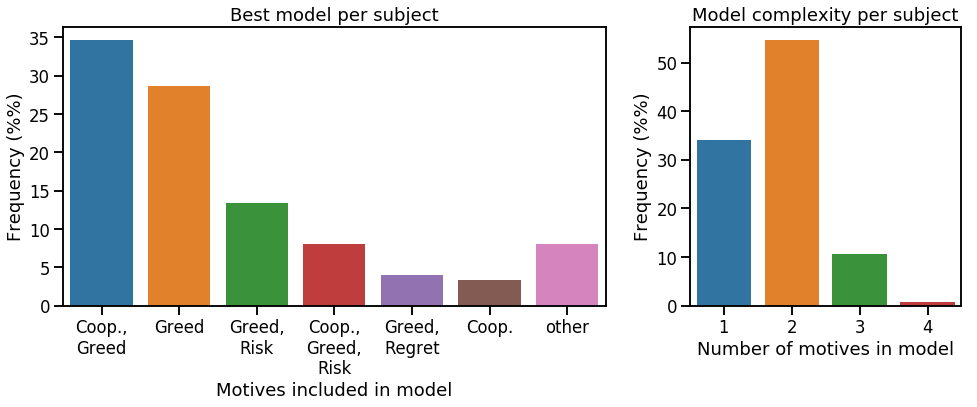

In [42]:
sns.set_context('talk')
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = [14,6], gridspec_kw = {'width_ratios':[2,1]});
sns.barplot(data = bestModelCounts_aggTrunc, x='comb_labels', y='pct',
            order = bestModelCounts_aggTrunc.comb_labels, ax = ax[0],
           palette = 'tab10')
ax[0].set(xlabel = 'Motives included in model', ylabel = 'Frequency (%%)',
       title = 'Best model per subject');
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=0)
sns.barplot(data = bestModelComplexityCounts, x='nDim', y='pct', order = [1,2,3,4], ax = ax[1])
ax[1].set(xlabel = 'Number of motives in model', ylabel = 'Frequency (%%)',
       title = 'Model complexity per subject');
plt.tight_layout()
# plt.savefig('/Users/jvanbaar/Desktop/modelComp_perSub_labels_pct.pdf',bbox_inches='tight',
#            transparent = True)

In [43]:
bestPerSubject_features = bestPerSubject.copy()
label_list = ['Coop.','Greed','Risk','Regret']
bestPerSubject_features['comb_labels'] = bestPerSubject_features['comb'].apply(lambda x: 
                ',\n'.join(label_list[k] for k in [i.span()[0] for i in re.finditer('1',x)]))
for feature in ['Coop','Greed','Risk','Regret']:
    bestPerSubject_features[feature] = bestPerSubject_features['comb_labels'].apply(lambda x: feature in x)
bestPerSubject_features.head()

,AIC,BIC,asymm_LR,bestModel,bestNLL,bounded_weights,comb,combInd,fitTo,param1,...,param7,param8,param9,subID,nDim,comb_labels,Coop,Greed,Risk,Regret
0,54.64,63.275532,0.0,1.0,23.32,1.0,1100,12.0,1.0,5.55,...,NaN,NaN,NaN,2003,2,"Coop.,\nGreed",True,True,False,False
1,70.56,77.036649,0.0,1.0,32.28,1.0,0100,4.0,1.0,1.10,...,NaN,NaN,NaN,2004,1,Greed,False,True,False,False
2,66.84,73.316649,0.0,1.0,30.42,0.0,0100,4.0,1.0,0.26,...,NaN,NaN,NaN,2005,1,Greed,False,True,False,False
3,61.18,67.656649,0.0,1.0,27.59,0.0,0100,4.0,1.0,0.15,...,NaN,NaN,NaN,2006,1,Greed,False,True,False,False
4,74.08,80.556649,0.0,1.0,34.04,1.0,0100,4.0,1.0,4.77,...,NaN,NaN,NaN,2008,1,Greed,False,True,False,False


In [44]:
featureCounts = pd.DataFrame(bestPerSubject_features[['Coop','Greed','Risk','Regret']].sum()).reset_index()
featureCounts.columns = ['Motive','Count']
featureCounts['pct'] = featureCounts['Count']/150
featureCounts.sort_values(by='Count', ascending = False, inplace=True)
featureCounts

,Motive,Count,pct
1,Greed,137,0.913333
0,Coop,76,0.506667
2,Risk,40,0.266667
3,Regret,14,0.093333


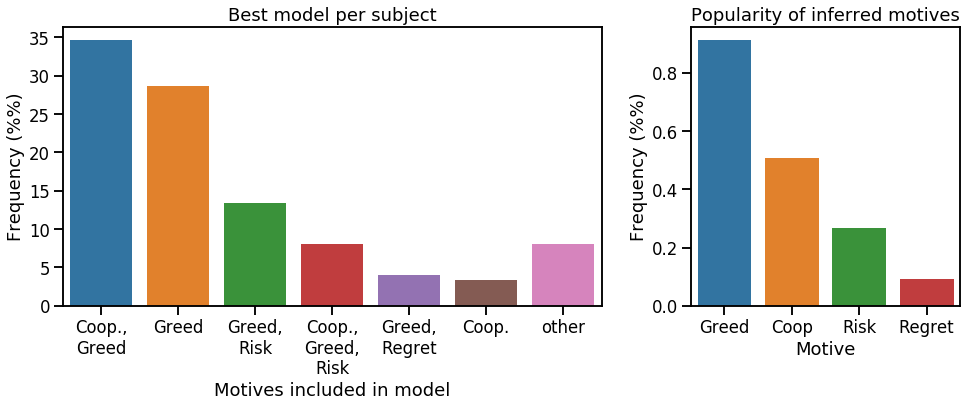

In [45]:
sns.set_context('talk')
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = [14,6], gridspec_kw = {'width_ratios':[2,1]});
sns.barplot(data = bestModelCounts_aggTrunc, x='comb_labels', y='pct',
            order = bestModelCounts_aggTrunc.comb_labels, ax = ax[0],
           palette = 'tab10')
ax[0].set(xlabel = 'Motives included in model', ylabel = 'Frequency (%%)',
       title = 'Best model per subject');
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=0)
sns.barplot(data = featureCounts, x='Motive', y='pct', ax = ax[1])
ax[1].set(xlabel = 'Motive', ylabel = 'Frequency (%%)',
       title = 'Popularity of inferred motives');
plt.tight_layout()
# plt.savefig('/Users/jvanbaar/Desktop/modelComp_perSub_labels_pct_withFeatureCounts.pdf',bbox_inches='tight',
#            transparent = True)

## Relationship between model features/complexity and performance

In [46]:
bestPerSubject.head()

,AIC,BIC,asymm_LR,bestModel,bestNLL,bounded_weights,comb,combInd,fitTo,param1,...,param2,param3,param4,param5,param6,param7,param8,param9,subID,nDim
0,54.64,63.275532,0.0,1.0,23.32,1.0,1100,12.0,1.0,5.55,...,0.43,1.29,9.08,NaN,NaN,NaN,NaN,NaN,2003,2
1,70.56,77.036649,0.0,1.0,32.28,1.0,0100,4.0,1.0,1.10,...,0.44,4.94,NaN,NaN,NaN,NaN,NaN,NaN,2004,1
2,66.84,73.316649,0.0,1.0,30.42,0.0,0100,4.0,1.0,0.26,...,0.36,4.81,NaN,NaN,NaN,NaN,NaN,NaN,2005,1
3,61.18,67.656649,0.0,1.0,27.59,0.0,0100,4.0,1.0,0.15,...,0.36,5.11,NaN,NaN,NaN,NaN,NaN,NaN,2006,1
4,74.08,80.556649,0.0,1.0,34.04,1.0,0100,4.0,1.0,4.77,...,0.31,3.59,NaN,NaN,NaN,NaN,NaN,NaN,2008,1


In [48]:
blockDat = blockDat.merge(bestPerSubject[['subID','nDim','comb']],on='subID')
blockDat.head()

,subID,Type_Total,Type,Variant,Confidence,Score,nDim,comb
0,2003,opt_inv,opt,inv,50.625,0.4375,2,1100
1,2003,opt_nat,opt,nat,89.375,1.0000,2,1100
2,2003,pess_inv,pess,inv,50.000,0.5000,2,1100
3,2003,pess_nat,pess,nat,52.500,0.5625,2,1100
4,2004,opt_inv,opt,inv,53.125,0.2500,1,0100


##### Merge data based on asymm_LR = 0, bounded_weights = 0, BIC (dataframe 'bestPerSubject')

In [49]:
totalDat = blockDat[['subID','Confidence','Score']].groupby(['subID']).mean().reset_index()
totalDat = totalDat.merge(bestPerSubject[['subID','nDim','comb']],on='subID')
totalDat.head()

,subID,Confidence,Score,nDim,comb
0,2003,60.62500,0.62500,2,1100
1,2004,62.03125,0.50000,1,0100
2,2005,61.71875,0.53125,1,0100
3,2006,45.15625,0.56250,1,0100
4,2008,75.00000,0.59375,1,0100


In [50]:
means = totalDat[['comb','nDim','Score']].groupby(['comb','nDim']).mean().sort_values(
    by='Score',ascending=False).reset_index()
combOrder = list(means['comb'].values)
print(combOrder)

['1111', '0111', '1110', '0010', '0110', '1101', '1010', '1001', '0100', '1100', '0101', '0011', '1011', '0001', '1000']


In [51]:
nDimOrder = list(means[['nDim','comb']].sort_values(by='nDim',ascending=False)['comb'].values)
print(nDimOrder)

['1111', '0111', '1110', '1101', '1011', '0110', '1010', '1001', '1100', '0101', '0011', '0010', '0100', '0001', '1000']


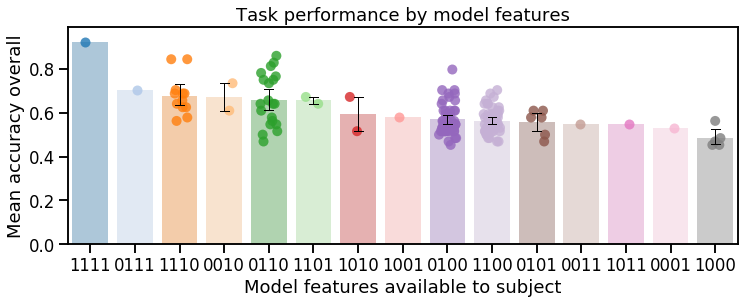

In [52]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = [12,4]);
sns.set_palette('tab10')
sns.barplot(data = totalDat, x = 'comb', y = 'Score', ax=ax, order = combOrder,
           alpha = .4, errwidth = 0, zorder = 0, palette = 'tab20');
[hand, lab] = ax.get_legend_handles_labels();
sns.stripplot(data = totalDat, x = 'comb', y = 'Score', ax=ax, order = combOrder, dodge=True,
           alpha = 0.8, size = 10, jitter = .2, zorder = 1, palette = 'tab20');
sns.barplot(data = totalDat, x = 'comb', y = 'Score', ax=ax, order = combOrder,
           alpha = 0, errwidth = 1, capsize = .2, errcolor = 'k', zorder = 2, palette = 'tab20');
ax.set(xlabel = 'Model features available to subject', ylabel = 'Mean accuracy overall', 
      title = 'Task performance by model features');
# plt.savefig('/Users/jvanbaar/Desktop/PerformanceByFeatureSet.pdf',bbox_inches='tight',
#            transparent = True)

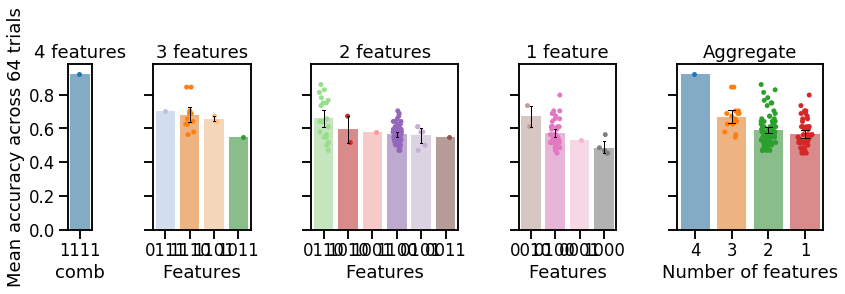

In [53]:
nCombsPernDim = [len(totalDat.query('nDim == @nDim')['comb'].unique()) for nDim in [4,3,2,1]]
nCombsPernDim.append(6)
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = [12,4], sharey=True,
                       gridspec_kw={'width_ratios':nCombsPernDim});
nPast = 0
for ndi,nDim in enumerate([4,3,2,1]):
    nCombs = len(totalDat.query('nDim == @nDim')['comb'].unique())
    if nCombs > 1:
        means = totalDat.query('nDim == @nDim')[['comb','nDim','Score']].groupby(
            ['comb','nDim']).mean().sort_values(by='Score',ascending=False).reset_index()
        combOrder = list(means['comb'].values)
    else:
        combOrder = ['1111']
    sns.barplot(data = totalDat.query('nDim == @nDim'), y = 'Score', x='comb', ax=ax[ndi],
           alpha = .6, errwidth = 0, zorder = 0, order = combOrder,
           palette = sns.color_palette('tab20')[nPast:(nPast+nCombs)]);
    sns.stripplot(data = totalDat.query('nDim == @nDim'), y = 'Score', x='comb', ax=ax[ndi],
           alpha = 1, zorder = 1, order = combOrder, size = 5, jitter = .2,
           palette = sns.color_palette('tab20')[nPast:(nPast+nCombs)]);
    sns.barplot(data = totalDat.query('nDim == @nDim'), y = 'Score', x='comb', ax=ax[ndi],
           alpha = 0, errwidth = 1, errcolor = 'k', capsize = .1, zorder = 2, order = combOrder,
           palette = sns.color_palette('tab20')[nPast:(nPast+nCombs)]);
    nPast = nPast + nCombs
ax[0].set(ylabel = 'Mean accuracy across 64 trials')
[ax[i].set(ylabel = '', xlabel = 'Features') for i in [1,2,3]]

sns.barplot(data = totalDat, x = 'nDim', y = 'Score', order = [4,3,2,1], ax = ax[4],
           alpha = .6, errwidth = 0, zorder = 0)
sns.stripplot(data = totalDat, x = 'nDim', y = 'Score', order = [4,3,2,1], ax = ax[4],
           alpha = 1, size = 5, jitter = .2, zorder = 1)
sns.barplot(data = totalDat, x = 'nDim', y = 'Score', order = [4,3,2,1], ax = ax[4],
           alpha = 0, errwidth = 1, errcolor = 'k', capsize = .2, zorder = 3)
[ax[i].set(title = '%i features'%(4-i)) for i in [0,1,2]]
ax[3].set(title = '1 feature')
ax[4].set(title = 'Aggregate', ylabel = '', xlabel = 'Number of features')
plt.tight_layout()
# plt.savefig('/Users/jvanbaar/Desktop/PerformanceByFeatureCount.pdf',bbox_inches='tight',
#            transparent = True)

In [54]:
print(scipy.stats.spearmanr(totalDat['nDim'],totalDat['Score']))
print(scipy.stats.f_oneway(totalDat.query('nDim == 1')['Score'],
                     totalDat.query('nDim == 2')['Score'],
                    totalDat.query('nDim == 3')['Score'],
                    totalDat.query('nDim == 4')['Score']))

SpearmanrResult(correlation=0.30672617467890245, pvalue=0.00013474146942351567)
F_onewayResult(statistic=11.650509550337915, pvalue=6.86725357154285e-07)


##### Exclude single subject in ndim = 4

In [55]:
print(scipy.stats.spearmanr(totalDat.query('nDim < 4')['nDim'],
                            totalDat.query('nDim < 4')['Score']))
print(scipy.stats.f_oneway(totalDat.query('nDim == 2')['Score'],
                    totalDat.query('nDim == 3')['Score'],
                    totalDat.query('nDim == 4')['Score']))

SpearmanrResult(correlation=0.29093788157495504, pvalue=0.00031867260679701914)
F_onewayResult(statistic=13.188948876831097, pvalue=8.695123183837322e-06)


##### Best subject

In [56]:
totalDat.query('nDim == 4')['subID'].unique()

array(['2133'], dtype=object)

In [57]:
gameDat.query('subID == "2133"')[['Type_Total','SelfReport']].drop_duplicates()

NameError: name 'gameDat' is not defined

##### Performance by Opt/Pess

In [209]:
relevant_feature_dat = blockDat[['subID','Confidence','Score','Type_Total']].copy()
relevant_feature_dat = relevant_feature_dat.merge(bestPerSubject[['subID','nDim','comb']],on='subID')
relevant_feature_dat['has_greed'] = relevant_feature_dat['comb'].apply(lambda x: x[1] == '1')
relevant_feature_dat['has_risk'] = relevant_feature_dat['comb'].apply(lambda x: x[2] == '1')
relevant_feature_dat.head()

,subID,Confidence,Score,Type_Total,nDim,comb,has_greed,has_risk
0,2003,50.625,0.4375,opt_inv,2,1100,True,False
1,2003,89.375,1.0000,opt_nat,2,1100,True,False
2,2003,50.000,0.5000,pess_inv,2,1100,True,False
3,2003,52.500,0.5625,pess_nat,2,1100,True,False
4,2004,53.125,0.2500,opt_inv,1,0100,True,False


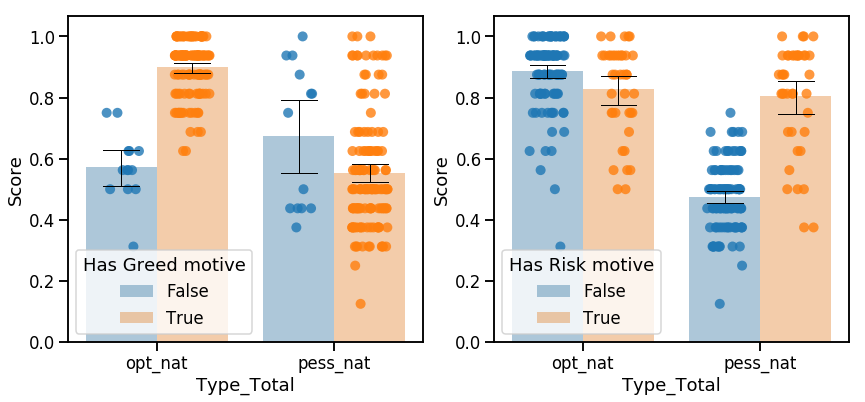

In [224]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = [14,6]);
sns.set_palette('tab10')
sns.barplot(data = relevant_feature_dat, hue = 'has_greed', y = 'Score', x = 'Type_Total',
            order = ['opt_nat','pess_nat'],
            ax=ax[0], alpha = .4, errwidth = 0, zorder = 0);
[hand, lab] = ax[0].get_legend_handles_labels();
sns.stripplot(data = relevant_feature_dat, hue = 'has_greed', y = 'Score', x = 'Type_Total', ax=ax[0],
              order = ['opt_nat','pess_nat'],
              dodge=True, alpha = 0.8, size = 10, jitter = .2, zorder = 1);
sns.barplot(data = relevant_feature_dat, hue = 'has_greed', y = 'Score', ax=ax[0], x = 'Type_Total',
            order = ['opt_nat','pess_nat'],
           alpha = 0, errwidth = 1, capsize = .2, errcolor = 'k', zorder = 2, palette = 'tab20');
ax[0].legend(hand,lab,title = 'Has Greed motive')

sns.barplot(data = relevant_feature_dat, hue = 'has_risk', y = 'Score', x = 'Type_Total',
            order = ['opt_nat','pess_nat'],
            ax=ax[1], alpha = .4, errwidth = 0, zorder = 0);
[hand, lab] = ax[1].get_legend_handles_labels();
sns.stripplot(data = relevant_feature_dat, hue = 'has_risk', y = 'Score', x = 'Type_Total', ax=ax[1],
              order = ['opt_nat','pess_nat'],
              dodge=True, alpha = 0.8, size = 10, jitter = .2, zorder = 1);
sns.barplot(data = relevant_feature_dat, hue = 'has_risk', y = 'Score', ax=ax[1], x = 'Type_Total',
            order = ['opt_nat','pess_nat'],
           alpha = 0, errwidth = 1, capsize = .2, errcolor = 'k', zorder = 2, palette = 'tab20');
ax[1].legend(hand,lab,title = 'Has Risk motive')
# plt.legend(hand,lab, loc = [1.1,.5])
# ax.set(xlabel = 'Model features available to subject', ylabel = 'Mean accuracy overall', 
#       title = 'Task performance by model features');
# # plt.savefig('/Users/jvanbaar/Desktop/PerformanceByFeatureSet.pdf',bbox_inches='tight',
# #            transparent = True)

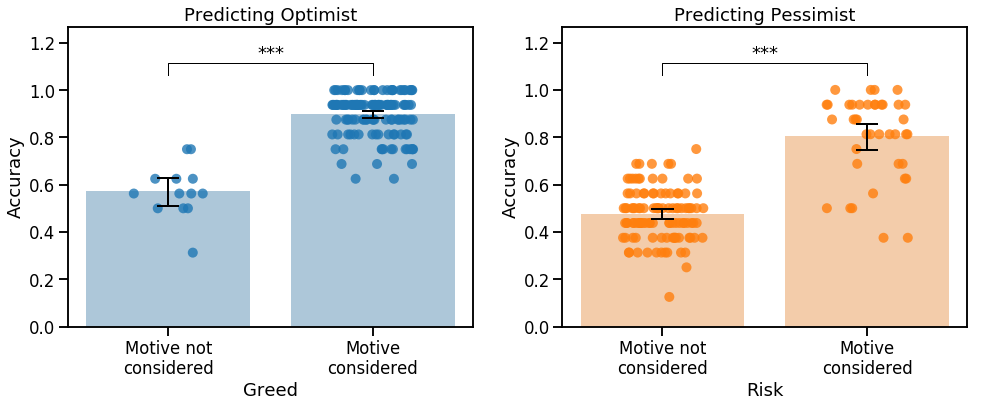

In [289]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = [14,6]);
sns.set_palette('tab10')
player_types = ['opt_nat','pess_nat']
lf_player_types = ['Optimist','Pessimist']
motive_columns = ['has_greed','has_risk']
lf_motive_columns = ['Greed','Risk']
colors = sns.color_palette('tab10')[:2]
for ai, ax in enumerate(axes.ravel()):
    player_type = player_types[ai]
    motive_column = motive_columns[ai]
    tmp = relevant_feature_dat.query('Type_Total == @player_type').copy()
    sns.barplot(data = tmp,
            x = motive_column, y = 'Score', ax=ax, alpha = .4, errwidth = 0, zorder = 0,
               color = colors[ai]);
# [hand, lab] = ax[0].get_legend_handles_labels();
    sns.stripplot(data = tmp,
            x = motive_column, y = 'Score', ax=ax, alpha = 0.8, size = 10, jitter = .2, zorder = 1,
               color = colors[ai]);
    sns.barplot(data = tmp,
            x = motive_column, y = 'Score', ax=ax,
            alpha = 0, errwidth = 2, capsize = .1, errcolor = 'k', zorder = 2,
               color = colors[ai]);
    ax.set(title = 'Predicting %s'%lf_player_types[ai], ylabel = 'Accuracy',
           xticklabels = ['Motive not\nconsidered', 'Motive\nconsidered'],
          xlabel = lf_motive_columns[ai])
    
    ttest_results = scipy.stats.ttest_ind(tmp.loc[tmp[motive_column],'Score'],
                                          tmp.loc[~tmp[motive_column],'Score'])
    pval = ttest_results[1]
    FigureTools.add_sig_markers(ax, relationships = [[0,1,pval]])
plt.tight_layout()
plt.savefig('/Users/jvanbaar/Desktop/PerformanceByMotive.pdf',bbox_inches='tight',
           transparent = True)

## Relationship between model features/complexity and response time

In [93]:
gameDat = pd.read_csv('gameDat_study1.csv',index_col = 0, dtype={ 'subID':str})
gameDat.head()

,sub,subID,Block,Player,Type,Variant,Type_Total,Trial,S,T,GameType,Colors,CorrAns,GivenAns,ConfidenceNum,ScoreNum,RT_radio,RT_submit,SelfReport
0,3,2003,0,G.P.,opt,nat,opt_nat,0,3,12,PD,"['Blue', 'Red']",def,def,70,1,10439,14310,maximize own score
1,3,2003,0,G.P.,opt,nat,opt_nat,1,7,8,HG,"['Blue', 'Red']",coop,coop,80,1,5259,8262,maximize own score
2,3,2003,0,G.P.,opt,nat,opt_nat,2,3,8,SH,"['Blue', 'Red']",coop,coop,80,1,2764,5519,maximize own score
3,3,2003,0,G.P.,opt,nat,opt_nat,3,7,12,SG,"['Blue', 'Red']",def,def,80,1,4497,7794,maximize own score
4,3,2003,0,G.P.,opt,nat,opt_nat,4,0,15,PD,"['Blue', 'Red']",def,def,70,1,12523,16207,maximize own score


In [94]:
gameDat['phase'] = gameDat['Trial'].apply(lambda x: 'early' if x < 8 else 'late')

In [95]:
gameDat['log_RT_radio'] = np.log(gameDat['RT_radio'] / 1000)
gameDat['log_RT_submit'] = np.log(gameDat['RT_submit'] / 1000)

In [96]:
gameDat['Trial_total'] = gameDat['Block']*16 + gameDat['Trial']

In [97]:
gameDat.head()

,sub,subID,Block,Player,Type,Variant,Type_Total,Trial,S,T,...,GivenAns,ConfidenceNum,ScoreNum,RT_radio,RT_submit,SelfReport,phase,log_RT_radio,log_RT_submit,Trial_total
0,3,2003,0,G.P.,opt,nat,opt_nat,0,3,12,...,def,70,1,10439,14310,maximize own score,early,2.345549,2.660959,0
1,3,2003,0,G.P.,opt,nat,opt_nat,1,7,8,...,coop,80,1,5259,8262,maximize own score,early,1.659941,2.111667,1
2,3,2003,0,G.P.,opt,nat,opt_nat,2,3,8,...,coop,80,1,2764,5519,maximize own score,early,1.016679,1.708197,2
3,3,2003,0,G.P.,opt,nat,opt_nat,3,7,12,...,def,80,1,4497,7794,maximize own score,early,1.503411,2.053354,3
4,3,2003,0,G.P.,opt,nat,opt_nat,4,0,15,...,def,70,1,12523,16207,maximize own score,early,2.527567,2.785443,4


In [118]:
type(plotDat['subID'][0])

str

In [119]:
type(phaseDat['subID'][0])

str

In [122]:
phaseDat = gameDat[['subID','Type_Total','phase','RT_radio','RT_submit']].groupby(
    ['subID','Type_Total','phase']).mean().reset_index()
phaseDat['log_RT_radio'] = np.log(phaseDat['RT_radio'] / 1000)
phaseDat['log_RT_submit'] = np.log(phaseDat['RT_submit'] / 1000)
phaseDat = phaseDat.merge(plotDat[['subID','comb','Risk']], on = 'subID', how = 'right').drop_duplicates()
phaseDat.head()

,subID,Type_Total,phase,RT_radio,RT_submit,log_RT_radio,log_RT_submit,comb,Risk
0,2003,opt_inv,early,4419.250,7059.000,1.485970,1.954303,1100,False
1,2003,opt_inv,late,2666.500,5190.750,0.980767,1.646878,1100,False
2,2003,opt_nat,early,5714.875,9405.750,1.743072,2.241321,1100,False
3,2003,opt_nat,late,2853.500,5802.250,1.048546,1.758246,1100,False
4,2003,pess_inv,early,2698.500,5472.875,0.992696,1.699804,1100,False


In [132]:
diffDat1 = phaseDat.query('phase == "early"')[['subID','Risk','Type_Total','log_RT_radio','log_RT_submit']]
diffDat2 = phaseDat.query('phase == "late"')[['subID','Risk','Type_Total','log_RT_radio','log_RT_submit']]
diffDat = diffDat1.merge(diffDat2, on = ['subID', 'Risk', 'Type_Total'], suffixes=['_e','_l'])
diffDat['log_RT_radio_diff'] = diffDat['log_RT_radio_l'] - diffDat['log_RT_radio_e']
diffDat['log_RT_submit_diff'] = diffDat['log_RT_submit_l'] - diffDat['log_RT_submit_e']
# diffDat['log_RT_radio_diff'] = np.log(diffDat['RT_radio_diff'] / 1000)
# diffDat['log_RT_submit_diff'] = np.log(diffDat['RT_submit_diff'] / 1000)
diffDat.head()

,subID,Risk,Type_Total,log_RT_radio_e,log_RT_submit_e,log_RT_radio_l,log_RT_submit_l,log_RT_radio_diff,log_RT_submit_diff
0,2003,False,opt_inv,1.485970,1.954303,0.980767,1.646878,-0.505203,-0.307425
1,2003,False,opt_nat,1.743072,2.241321,1.048546,1.758246,-0.694526,-0.483075
2,2003,False,pess_inv,0.992696,1.699804,1.010464,1.692330,0.017768,-0.007474
3,2003,False,pess_nat,1.693296,2.157097,1.461576,1.989705,-0.231721,-0.167392
4,2004,False,opt_inv,1.650508,1.930887,1.391375,1.699987,-0.259133,-0.230900


/Applications/anaconda3/envs/structLearn/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


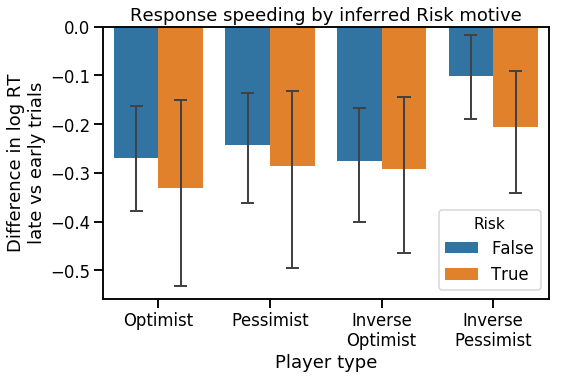

In [141]:
fig, ax = plt.subplots(1,1, figsize = [8,5])
sns.barplot(data = diffDat, x = 'Type_Total', hue = 'Risk', y = 'log_RT_radio_diff', 
           order = ['opt_nat','pess_nat', 'opt_inv','pess_inv'], ax = ax, capsize = .1, errwidth = 2)
ax.set(ylabel = 'Difference in log RT\nlate vs early trials', title = 'Response speeding by inferred Risk motive', xlabel = 'Player type',
      xticklabels = ['Optimist','Pessimist','Inverse\nOptimist','Inverse\nPessimist'])
plt.savefig('/Users/jvanbaar/Desktop/Speeded_response.pdf',bbox_inches = 'tight', transparent = True)

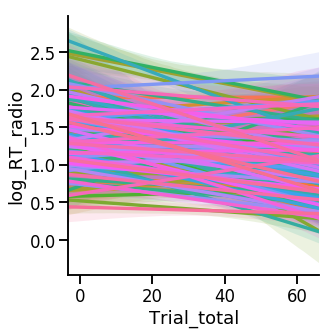

In [92]:
sns.lmplot(data = gameDat, x = 'Trial_total', y = 'log_RT_radio', hue = 'subID', scatter = False, legend = False)

In [69]:
RTdat = gameDat[['subID','Type_Total','RT_radio','RT_submit']
               ].groupby(['subID','Type_Total']).sum().reset_index()
RTdat.head()

,subID,Type_Total,RT_radio,RT_submit
0,04000,opt_inv,51392,75526
1,04000,opt_nat,61995,90589
2,04000,pess_inv,64595,91490
3,04000,pess_nat,81852,108421
4,04001,opt_inv,36924,63762


In [70]:
RTdat = RTdat.merge(bestPerSubject[['subID','nDim','comb']],on='subID')
RTdat['log_RT_radio'] = np.log(RTdat['RT_radio'] / 1000)
RTdat['log_RT_submit'] = np.log(RTdat['RT_submit'] / 1000)
RTdat.head()

,subID,Type_Total,RT_radio,RT_submit,nDim,comb,log_RT_radio,log_RT_submit
0,2003,opt_inv,56686,97998,2,1100,4.037527,4.584947
1,2003,opt_nat,68547,121664,2,1100,4.227520,4.801263
2,2003,pess_inv,43563,87240,2,1100,3.774208,4.468663
3,2003,pess_nat,78001,127675,2,1100,4.356722,4.849488
4,2004,opt_inv,73840,98956,1,0100,4.301901,4.594675


##### Total game time

In [72]:
RTdatOverall = RTdat[['subID','RT_radio','RT_submit','nDim','comb']].groupby(
    ['subID','nDim','comb']).sum().reset_index()
RTdatOverall['log_RT_radio'] = np.log(RTdatOverall['RT_radio'] / 1000)
RTdatOverall['log_RT_submit'] = np.log(RTdatOverall['RT_submit'] / 1000)
RTdatOverall.head()

,subID,nDim,comb,RT_radio,RT_submit,log_RT_radio,log_RT_submit
0,2003,2,1100,246797,434577,5.508566,6.074373
1,2004,1,0100,331818,457653,5.804587,6.126111
2,2005,1,0100,364659,534371,5.898963,6.281090
3,2006,1,0100,322376,432898,5.775719,6.070502
4,2008,1,0100,568010,699874,6.342139,6.550900


In [73]:
# RTdatOverall_unitS = RTdatOverall.copy()
# RTdatOverall_unitS['RT_radio'] = RTdatOverall_unitS['RT_radio']/1000
# RTdatOverall_unitS['RT_submit'] = RTdatOverall_unitS['RT_submit']/1000
# RTdatOverall_unitS.head()

##### Remove outliers

In [154]:
RTdatOverall_unitS = RTdatOverall_unitS.query('RT_submit < 2000').copy()

##### Plot

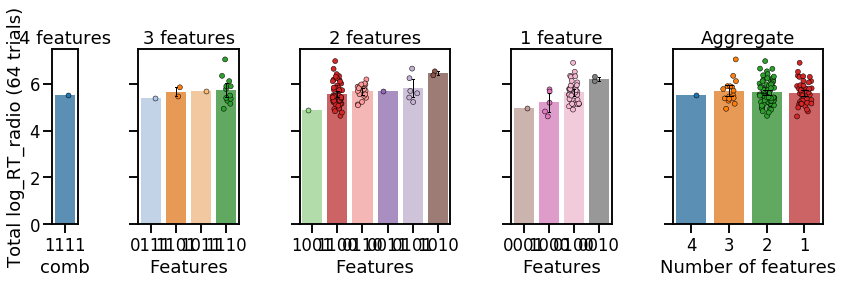

In [76]:
plotDat = RTdatOverall.copy()
RTchoice = 'log_RT_radio' # Can be 'RT_radio' or 'RT_submit'

nCombsPernDim = [len(plotDat.query('nDim == @nDim')['comb'].unique()) for nDim in [4,3,2,1]]
nCombsPernDim.append(6)
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = [12,4], sharey=True,
                       gridspec_kw={'width_ratios':nCombsPernDim});
nPast = 0
for ndi,nDim in enumerate([4,3,2,1]):
    nCombs = len(plotDat.query('nDim == @nDim')['comb'].unique())
    if nCombs > 1:
        means = plotDat.query('nDim == @nDim')[['comb','nDim',RTchoice]].groupby(
            ['comb','nDim']).mean().sort_values(by=RTchoice,ascending=True).reset_index()
        combOrder = list(means['comb'].values)
    else:
        combOrder = ['1111']
    sns.barplot(data = plotDat.query('nDim == @nDim'), y = RTchoice, x='comb', ax=ax[ndi],
           alpha = .8, errwidth = 0, zorder = 0, order = combOrder,
           palette = sns.color_palette('tab20')[nPast:(nPast+nCombs)]);
    sns.stripplot(data = plotDat.query('nDim == @nDim'), y = RTchoice, x='comb', ax=ax[ndi],
           alpha = 1, zorder = 1, order = combOrder, size = 5, jitter = .2,
           edgecolor = 'k', linewidth=.5, palette = sns.color_palette('tab20')[nPast:(nPast+nCombs)]);
    sns.barplot(data = plotDat.query('nDim == @nDim'), y = RTchoice, x='comb', ax=ax[ndi],
           alpha = 0, errwidth = 1, errcolor = 'k', capsize = .1, zorder = 2, order = combOrder,
           palette = sns.color_palette('tab20')[nPast:(nPast+nCombs)]);
    nPast = nPast + nCombs
ax[0].set(ylabel = 'Total %s (64 trials)'%RTchoice)
[ax[i].set(ylabel = '', xlabel = 'Features') for i in [1,2,3]]

sns.barplot(data = plotDat, x = 'nDim', y = RTchoice, order = [4,3,2,1], ax = ax[4],
           alpha = .8, errwidth = 0, zorder = 0)
sns.stripplot(data = plotDat, x = 'nDim', y = RTchoice, order = [4,3,2,1], ax = ax[4],
           alpha = 1, size = 5, jitter = .2, zorder = 1, edgecolor = 'k', linewidth=.5)
sns.barplot(data = plotDat, x = 'nDim', y = RTchoice, order = [4,3,2,1], ax = ax[4],
           alpha = 0, errwidth = 1, errcolor = 'k', capsize = .2, zorder = 3)
[ax[i].set(title = '%i features'%(4-i)) for i in [0,1,2]]
ax[3].set(title = '1 feature')
ax[4].set(title = 'Aggregate', ylabel = '', xlabel = 'Number of features')
plt.tight_layout()
# plt.savefig('/Users/jvanbaar/Desktop/RTByFeatureCount.pdf',bbox_inches='tight',
#            transparent = True)

In [77]:
print(scipy.stats.pearsonr(plotDat['nDim'],plotDat[RTchoice]))
print(scipy.stats.f_oneway(plotDat.query('nDim == 1')[RTchoice],
                     plotDat.query('nDim == 2')[RTchoice],
                    plotDat.query('nDim == 3')[RTchoice],
                    plotDat.query('nDim == 4')[RTchoice]))

(0.05062024999825717, 0.5412046830601187)
F_onewayResult(statistic=0.1878324306349182, pvalue=0.9045442013102246)


## RT by condition per model motive

In [78]:
plotDat = RTdat.copy()
label_list = ['Coop.','Greed','Risk','Regret']
plotDat['comb_labels'] = plotDat['comb'].apply(lambda x: 
                ',\n'.join(label_list[k] for k in [i.span()[0] for i in re.finditer('1',x)]))
for feature in ['Coop','Greed','Risk','Regret']:
    plotDat[feature] = plotDat['comb_labels'].apply(lambda x: feature in x)
plotDat.head()

,subID,Type_Total,RT_radio,RT_submit,nDim,comb,log_RT_radio,log_RT_submit,comb_labels,Coop,Greed,Risk,Regret
0,2003,opt_inv,56686,97998,2,1100,4.037527,4.584947,"Coop.,\nGreed",True,True,False,False
1,2003,opt_nat,68547,121664,2,1100,4.227520,4.801263,"Coop.,\nGreed",True,True,False,False
2,2003,pess_inv,43563,87240,2,1100,3.774208,4.468663,"Coop.,\nGreed",True,True,False,False
3,2003,pess_nat,78001,127675,2,1100,4.356722,4.849488,"Coop.,\nGreed",True,True,False,False
4,2004,opt_inv,73840,98956,1,0100,4.301901,4.594675,Greed,False,True,False,False


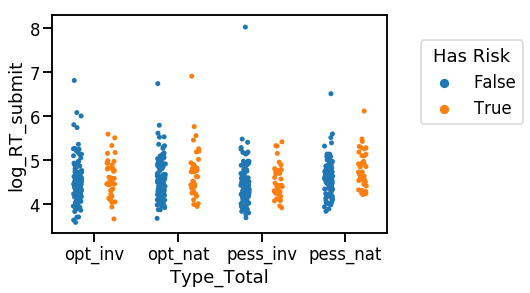

In [85]:
motive = 'Risk'
sns.stripplot(data = plotDat, x = 'Type_Total', y = 'log_RT_submit', hue = motive, dodge = True)
plt.legend(loc=[1.1,.5], title = 'Has %s'%motive)

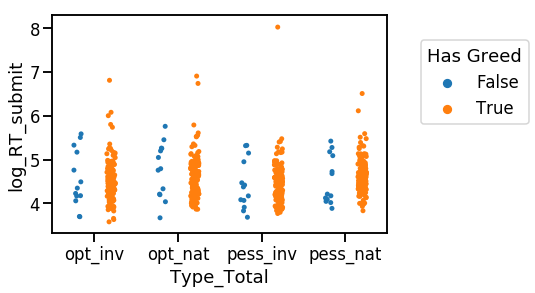

In [86]:
motive = 'Greed'
sns.stripplot(data = plotDat, x = 'Type_Total', y = 'log_RT_submit', hue = motive, dodge = True)
plt.legend(loc=[1.1,.5], title = 'Has %s'%motive)

## Which dimensions are used by people from the Coop, Opt, and Pess groups (self-report)?

In [127]:
baseDir = '/Users/jvanbaar/Dropbox (Brown)/Postdoc FHL/JEROEN/SOC_STRUCT_LEARN/'

In [128]:
DIYquiz = pd.read_csv(baseDir+'Study1_MTurk/Data/Cleaned/DIYquiz.csv',
                      dtype = {'subID':str}, index_col=0)
DIYquiz.head()

,sub,subID,selfType,typicalType
0,3,2003,opt,opt
1,4,2004,trust,none
2,5,2005,trust,trust
3,6,2006,trust,trust
4,8,2008,none,none


In [129]:
type(DIYquiz['subID'].values[0])

str

In [130]:
DIYquiz = DIYquiz.merge(bestPerSubject[['subID','comb','nDim']], on='subID')
DIYquiz.head()

,sub,subID,selfType,typicalType,comb,nDim
0,3,2003,opt,opt,1100,2
1,4,2004,trust,none,0100,1
2,5,2005,trust,trust,0100,1
3,6,2006,trust,trust,0100,1
4,8,2008,none,none,0100,1


In [131]:
combs = DIYquiz['comb'].unique()
combs.sort()
combs

array(['0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000',
       '1001', '1010', '1011', '1100', '1101', '1110', '1111'],
      dtype=object)

In [175]:
combCountsAll = pd.DataFrame(columns=combs, index=DIYquiz['selfType'].unique())
combCountsAll[:] = 0
combCountsAll
for st in DIYquiz['selfType'].unique():
    combCounts = DIYquiz.loc[DIYquiz['selfType']==st,'comb'].value_counts(dropna=False)
    for comb in combCounts.index.values:
        combCountsAll.loc[st, comb] = combCounts[comb]
combCountsAll

,0001,0010,0011,0100,0101,0110,0111,1000,1001,1010,1011,1100,1101,1110,1111
opt,1,0,0,8,1,2,0,0,0,1,1,9,0,1,0
trust,0,0,0,21,2,4,1,2,1,0,0,28,2,4,0
none,0,1,0,10,3,3,0,2,0,0,0,10,0,4,0
other_opt,0,1,0,1,0,3,0,0,0,1,0,3,0,1,0
pess,0,0,0,1,0,6,0,0,0,0,0,2,0,2,1
env,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0


In [176]:
# combCountsAll = combCountsAll.iloc[[0,4,1],:]
combCountsAll_other = pd.DataFrame(combCountsAll.iloc[[2,3,5],:].sum(axis=0))
combCountsAll_other.columns = ['other']
combCountsAll_other = combCountsAll_other.T
# combCountsAll_other
combCountsAll = combCountsAll.iloc[[0,4,1],:].append(combCountsAll_other)
combCountsAll
# fbg_red = fbg_red.append(mean_other)

,0001,0010,0011,0100,0101,0110,0111,1000,1001,1010,1011,1100,1101,1110,1111
opt,1,0,0,8,1,2,0,0,0,1,1,9,0,1,0
pess,0,0,0,1,0,6,0,0,0,0,0,2,0,2,1
trust,0,0,0,21,2,4,1,2,1,0,0,28,2,4,0
other,0,2,1,12,3,7,0,3,0,1,0,13,0,5,0


In [177]:
combCountsAllShare = combCountsAll.copy()
for st in combCountsAllShare.index:
#     vals = combCountsAllShare.loc[st,:].values
    combCountsAllShare.loc[st,:] = np.divide(combCountsAllShare.loc[st,:], 
                                 np.sum(combCountsAllShare.loc[st,:].values))
combCountsAllShare

,0001,0010,0011,0100,0101,0110,0111,1000,1001,1010,1011,1100,1101,1110,1111
opt,0.041667,0.000000,0.000000,0.333333,0.041667,0.083333,0.000000,0.000000,0.000000,0.041667,0.041667,0.375000,0.000000,0.041667,0.000000
pess,0.000000,0.000000,0.000000,0.083333,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.166667,0.083333
trust,0.000000,0.000000,0.000000,0.323077,0.030769,0.061538,0.015385,0.030769,0.015385,0.000000,0.000000,0.430769,0.030769,0.061538,0.000000
other,0.000000,0.042553,0.021277,0.255319,0.063830,0.148936,0.000000,0.063830,0.000000,0.021277,0.000000,0.276596,0.000000,0.106383,0.000000


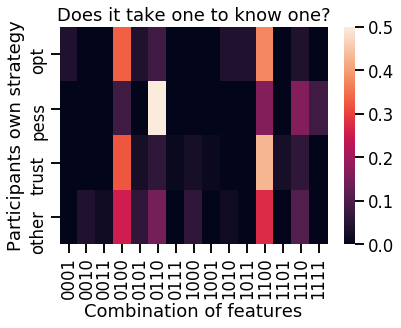

In [178]:
sns.set_context('talk')
fig, ax = plt.subplots(nrows = 1, ncols = 1);
sns.heatmap(combCountsAllShare, ax=ax)
ax.set(xlabel = 'Combination of features', ylabel = 'Participant''s own strategy', 
       title = 'Does it take one to know one?');
# plt.savefig('/Users/jvanbaar/Desktop/featuresByOwnType.pdf',bbox_inches='tight');

In [184]:
combs_considered = combCountsAllShare.columns
featuresByGroup = pd.DataFrame(columns=[0,1,2,3], index = combCountsAllShare.index)
featuresByGroup[:] = 0
for feature in [0,1,2,3]:
    columnsToCheck = []
    for comb in combs_considered:
        if comb[feature]=='1':
            columnsToCheck.append(comb)
    for st in combCountsAllShare.index:
        featuresByGroup.loc[st, feature] = np.sum(combCountsAllShare.loc[st, columnsToCheck])
featuresByGroup = featuresByGroup*100
featuresByGroup

,0,1,2,3
opt,50.000000,87.500000,20.833333,12.500000
pess,41.666667,100.000000,75.000000,8.333333
trust,56.923077,95.384615,13.846154,9.230769
other,46.808511,85.106383,34.042553,8.510638


In [185]:
# fbg_red = featuresByGroup.iloc[[0,4,1],:]
# mean_other = pd.DataFrame(featuresByGroup.iloc[[2,3,5],:].mean(axis=0))
# mean_other.columns = ['other']
# mean_other = mean_other.T
# fbg_red = fbg_red.append(mean_other)
# fbg_red

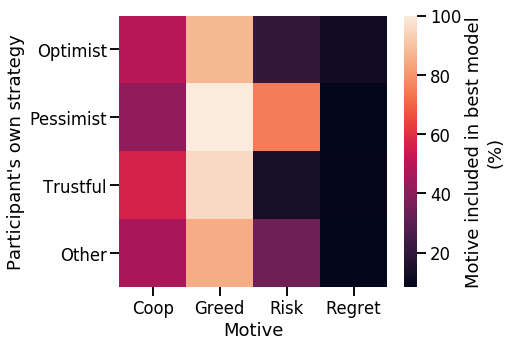

In [192]:
sns.set_context('talk')
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = [6,5]);
sns.heatmap(featuresByGroup, ax=ax, cbar_kws = {'label':'Motive included in best model\n(%)'})
ax.set(xlabel = 'Motive', ylabel = 'Participant\'s own strategy', 
#        title = 'Frequency of motives inferred',
       xticklabels = ['Coop','Greed','Risk','Regret'],
      yticklabels = ['Optimist','Pessimist','Trustful','Other']
      );
plt.yticks(rotation = 0);
plt.savefig('/Users/jvanbaar/Desktop/featuresByOwnType_reduced_pct.pdf',bbox_inches='tight',
           transparent = True);